In [60]:
import pretty_midi
import numpy as np
from scipy.spatial.distance import cosine

def get_chromagram(midi_file, fs=12):
    """
    Obtiene el chromagram de un archivo MIDI usando pretty_midi.
    fs: frames por beat
    """
    pm = pretty_midi.PrettyMIDI(midi_file)
    beats = pm.get_beats()
    
    if len(beats) < 2:
        raise ValueError("No se detectaron beats suficientes.")

    # Duración total en segundos
    #total_time = beats[-1]
    #print(f"Duración total del MIDI: {total_time:.4f} segundos")
    #total_time = pm.get_end_time()
    #print(f"Duración total del MIDI (usando get_end_time): {total_time:.4f} segundos")
    # Duración total en segundos: final última nota real (de esta forma evitamos silencios en MIDIs truncados)
    total_time = max(
        note.end
        for instrument in pm.instruments
        for note in instrument.notes
    )
    #print(f"Duración total del MIDI (última nota real): {total_time:.4f} segundos")

    # Tasa de muestreo en Hz
    beat_duration = np.median(np.diff(beats))
    hop_length = beat_duration / fs  # Segundos por frame

    times = np.arange(0, total_time, hop_length)

    chroma = pm.get_chroma(times=times)
    #print(f"Beat duration: {beat_duration:.4f} segundos")
    #print(f"Total time: {total_time:.4f} segundos")
    #print(f"Hop length: {hop_length:.4f} segundos")
    #print(f"Número de segmentos en el chroma: {chroma.shape[1]}")
    return chroma

def smooth_chromagram(chroma, window_frames=24, stride_frames=12):
    """
    Suaviza el chromagram usando media móvil.
    """
    smoothed = []
    for start in range(0, chroma.shape[1] - window_frames + 1, stride_frames):
        window = chroma[:, start:start+window_frames]
        avg = np.mean(window, axis=1)
        smoothed.append(avg)
    return np.array(smoothed).T  # Vuelve a forma (12, num_windows)

def framewise_cosine_similarity(chroma1, chroma2):
    num_frames = min(chroma1.shape[1], chroma2.shape[1])
    sims = []
    for i in range(num_frames):
        vec1 = chroma1[:, i]
        vec2 = chroma2[:, i]
        if np.all(vec1 == 0) and np.all(vec2 == 0):
            sims.append(1.0)
            continue
        if np.all(vec1 == 0) or np.all(vec2 == 0):
            sims.append(0.0)
            continue
        sim = 1 - cosine(vec1, vec2)
        sims.append(sim)
    return np.mean(sims)

def compute_content_preservation(original_midi, transferred_midi):
    """
    Computa el Content Preservation Score usando el método de Lu & Su.
    """
    # Paso 1: Chromagram
    chroma_original = get_chromagram(original_midi)
    chroma_transformed = get_chromagram(transferred_midi)
    
    # Asegurarse de que ambos chromas tengan la misma cantidad de frames
    min_frames = min(chroma_original.shape[1], chroma_transformed.shape[1])
    print("Los chromas tienen diferente número de frames. Ajustando...")
    print(f"Original: {chroma_original.shape[1]} frames, Transformado: {chroma_transformed.shape[1]} frames")
    chroma_original = chroma_original[:, :min_frames]
    chroma_transformed = chroma_transformed[:, :min_frames]
    print(f"Después del ajuste: {chroma_original.shape[1]} frames, {chroma_transformed.shape[1]} frames")

    # Paso 2: Suavizado (2 beats window, stride 1 beat)
    smooth_orig = smooth_chromagram(chroma_original, window_frames=24, stride_frames=12)
    smooth_trans = smooth_chromagram(chroma_transformed, window_frames=24, stride_frames=12)

    # Paso 3: Framewise Cosine Similarity
    score = framewise_cosine_similarity(smooth_orig, smooth_trans)
    return score

In [89]:
# -----------------------
# ✅ Prueba
# -----------------------
#original = "test_data/original.mid"
#transferred = "test_data/transferred.mid"
cancion = "canned heat"
original = "metrics test/"+ cancion +".mid"
transferred = "metrics test/" + cancion + "__zelda__remix.mid"
chroma_original = get_chromagram(original)
chroma_transformed = get_chromagram(transferred)

if chroma_original.shape[1] != chroma_transformed.shape[1]:
    min_frames = min(chroma_original.shape[1], chroma_transformed.shape[1])
    chroma_original = chroma_original[:, :min_frames]
    chroma_transformed = chroma_transformed[:, :min_frames]

score = compute_content_preservation(original, transferred)
print(f"Content Preservation Score: {score:.4f}")


Los chromas tienen diferente número de frames. Ajustando...
Original: 5280 frames, Transformado: 5185 frames
Después del ajuste: 5185 frames, 5185 frames
Content Preservation Score: 0.7796


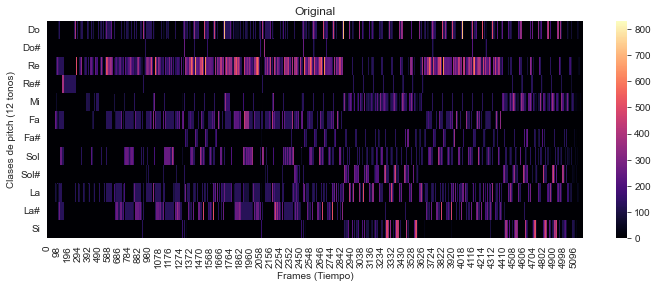

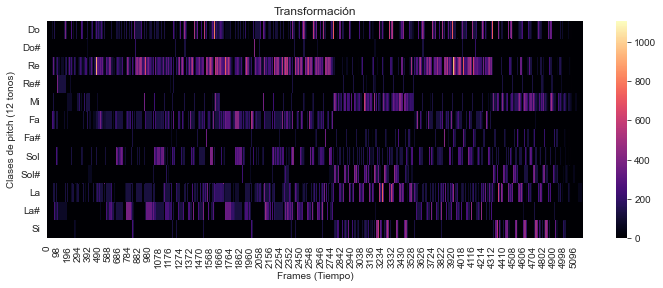

In [97]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

def plot_chromagram(chroma, title="Chromagram"):
    plt.figure(figsize=(12, 4))
    sns.heatmap(chroma, cmap="magma", cbar=True)
    plt.xlabel("Frames (Tiempo)")
    plt.ylabel("Clases de pitch (12 tonos)")
    plt.title(title)
    plt.yticks(ticks=np.arange(12)+0.5, labels=[
        'Do', 'Do#', 'Re', 'Re#', 'Mi', 'Fa', 'Fa#', 'Sol', 'Sol#', 'La', 'La#', 'Si'
    ], rotation=0)
    plt.show()


# Ejemplo de uso:
plot_chromagram(chroma_original, title="Original")
plot_chromagram(chroma_transformed, title="Transformación")

In [ ]:
# Datos misceláneos
def total_notes(midi_path):
    pm = pretty_midi.PrettyMIDI(midi_path)
    return sum(len(inst.notes) for inst in pm.instruments)

print(f"Diferencia en número de instrumentos en %: {100 * abs(len(pretty_midi.PrettyMIDI(original).instruments) - len(pretty_midi.PrettyMIDI(transferred).instruments)) / len(pretty_midi.PrettyMIDI(transferred).instruments):.2f}%")


notas_original = total_notes(original)
notas_transferido = total_notes(transferred)
diferencia = 100 * abs(notas_original - notas_transferido) / notas_transferido
print(f"Diferencia en número de notas totales en %: {diferencia:.2f}%")

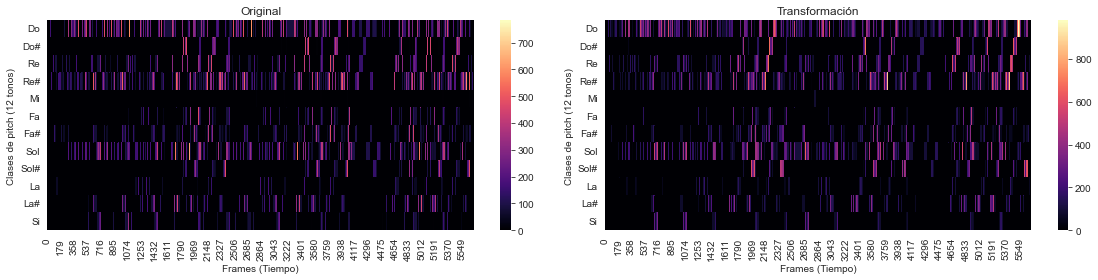

In [21]:
def plot_two_chromagrams(chroma1, chroma2, title1="Original", title2="Transformación"):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    fig, axs = plt.subplots(1, 2, figsize=(16, 4))
    for ax, chroma, title in zip(axs, [chroma1, chroma2], [title1, title2]):
        sns.heatmap(chroma, cmap="magma", cbar=True, ax=ax)
        ax.set_xlabel("Frames (Tiempo)")
        ax.set_ylabel("Clases de pitch (12 tonos)")
        ax.set_title(title)
        ax.set_yticks(np.arange(12)+0.5)
        ax.set_yticklabels([
            'Do', 'Do#', 'Re', 'Re#', 'Mi', 'Fa', 'Fa#', 'Sol', 'Sol#', 'La', 'La#', 'Si'
        ], rotation=0)
    plt.tight_layout()
    plt.show()
    
plot_two_chromagrams(chroma_original, chroma_transformed, title1="Original", title2="Transformación")